In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from EEGModels import EEGNet
from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

Automatically created module for IPython interactive environment


In [6]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy_lib

In [7]:
import h5py

In [8]:
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K

In [9]:
# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subjects = range(1,10)
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subjects, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.annotations.rename(dict(T1="hands", T2="feet"))  # as documented on PhysioNet
raw.set_eeg_reference(projection=True)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    event_id=["hands", "feet"],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /Users/isita/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extr

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Used Annotations descriptions: ['T0', 'feet', 'hands']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
405 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 405 events and 801 original time points ...
0 bad epochs dropped


In [52]:
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

In [53]:
labels

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,

In [33]:
# labels = np_utils.to_categorical(labels)

In [197]:
# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels

kernels, chans, samples = 1, 64, 801

In [198]:
print(X.shape, y.shape)

(405, 64, 801) (405,)


In [241]:
X_train      = X[0:224,]
Y_train      = y[0:224]
X_validate   = X[224:320,]
Y_validate   = y[224:320]
X_test       = X[320:416]
Y_test       = y[320:416]

In [242]:
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)
   
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (224, 64, 801, 1)
224 train samples
85 test samples


In [243]:
l2_norm_clip = 1.5
noise_multiplier = 1.5 # was 1.3
batch_size = 16
num_microbatches = 16
learning_rate = 0.25
batch_size = 16

In [244]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples,
               dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
               dropoutType = 'Dropout')

In [245]:
optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=1.0,      # Gradient clipping norm
    noise_multiplier=noise_multiplier,  # Controls privacy strength (lower = more privacy)
    num_microbatches=num_microbatches, # Use per-example gradients
    learning_rate=0.001
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)

In [246]:
# compile the model and set the optimizers
model.compile(loss=loss, 
              optimizer=optimizer,
              metrics = ['accuracy'])

In [247]:
import time

class timing(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
    
    def on_train_end(self, logs=None):
        self.total_time = time.time() - self.start_time
        print(f"Total training time: {self.total_time:.2f} seconds")

In [248]:




# count number of parameters in the model
numParams    = model.count_params()    

# set a valid path for your system to record model checkpoints
with h5py.File('./tmp/checkpoint.h5', 'w') as f:
    # This creates 2 attributes of arrays of different np.float types:
    arr_in = np.array([1.0,2.0,3.0])
    f.attrs['as_float64'] = arr_in
    # arr_in.dtype = np.float128
    # f.attrs['as_float128'] = arr_in
checkpointer = ModelCheckpoint(filepath='./tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)

###############################################################################
# if the classification task was imbalanced (significantly more trials in one
# class versus the others) you can assign a weight to each class during 
# optimization to balance it out. This data is approximately balanced so we 
# don't need to do this, but is shown here for illustration/completeness. 
###############################################################################

# the syntax is {class_1:weight_1, class_2:weight_2,...}. Here just setting
# the weights all to be 1
class_weights = {0:1, 1:1}

################################################################################
# fit the model. Due to very small sample sizes this can get
# pretty noisy run-to-run, but most runs should be comparable to xDAWN + 
# Riemannian geometry classification (below)
################################################################################
fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = 100, 
                        verbose = 2, validation_data=(X_validate, Y_validate),
                        # callbacks=[checkpointer],
                        callbacks=[timing()],
                        class_weight = class_weights)

Train on 224 samples, validate on 96 samples


2025-06-10 08:03:59.024281: W tensorflow/c/c_api.cc:305] Operation '{name:'batch_normalization_31/moving_variance/Assign' id:22468 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_31/moving_variance/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_31/moving_variance, batch_normalization_31/moving_variance/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/100


/opt/anaconda3/envs/zazu2/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


224/224 - 9s - loss: 0.7134 - acc: 0.4821 - val_loss: 0.6932 - val_acc: 0.4896 - 9s/epoch - 42ms/sample
Epoch 2/100
224/224 - 9s - loss: 0.6926 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.4896 - 9s/epoch - 40ms/sample
Epoch 3/100
224/224 - 9s - loss: 0.6953 - acc: 0.4955 - val_loss: 0.6932 - val_acc: 0.4896 - 9s/epoch - 41ms/sample
Epoch 4/100
224/224 - 9s - loss: 0.6933 - acc: 0.5089 - val_loss: 0.6932 - val_acc: 0.4896 - 9s/epoch - 41ms/sample
Epoch 5/100
224/224 - 9s - loss: 0.6843 - acc: 0.5312 - val_loss: 0.6932 - val_acc: 0.4896 - 9s/epoch - 39ms/sample
Epoch 6/100
224/224 - 9s - loss: 0.6900 - acc: 0.5312 - val_loss: 0.6933 - val_acc: 0.4896 - 9s/epoch - 39ms/sample
Epoch 7/100
224/224 - 9s - loss: 0.6928 - acc: 0.5134 - val_loss: 0.6933 - val_acc: 0.4896 - 9s/epoch - 39ms/sample
Epoch 8/100
224/224 - 9s - loss: 0.6884 - acc: 0.5268 - val_loss: 0.6933 - val_acc: 0.4896 - 9s/epoch - 39ms/sample
Epoch 9/100
224/224 - 9s - loss: 0.6883 - acc: 0.5223 - val_loss: 0.6933 - val_acc: 

In [249]:
# load optimal weights
# model.load_weights('./tmp/checkpoint.h5')

###############################################################################
# can alternatively used the weights provided in the repo. If so it should get
# you 93% accuracy. Change the WEIGHTS_PATH variable to wherever it is on your
# system.
###############################################################################

# WEIGHTS_PATH = /path/to/EEGNet-8-2-weights.h5 
# model.load_weights(WEIGHTS_PATH)

###############################################################################
# make prediction on test set.
###############################################################################

probs       = model.predict(X_test)
preds       = probs.argmax(axis = -1)  
acc         = np.mean(preds == Y_test.argmax(axis=-1))
print("Classification accuracy: %f " % (acc))


############################# PyRiemann Portion ##############################

# code is taken from PyRiemann's ERP sample script, which is decoding in 
# the tangent space with a logistic regression

# n_components = 2  # pick some components

# # set up sklearn pipeline
# clf = make_pipeline(XdawnCovariances(n_components),
#                     TangentSpace(metric='riemann'),
#                     LogisticRegression())

# preds_rg     = np.zeros(len(Y_test))

# # reshape back to (trials, channels, samples)
# X_train      = X_train.reshape(X_train.shape[0], chans, samples)
# X_test       = X_test.reshape(X_test.shape[0], chans, samples)

# # train a classifier with xDAWN spatial filtering + Riemannian Geometry (RG)
# # labels need to be back in single-column format
# clf.fit(X_train, Y_train.argmax(axis = -1))
# preds_rg     = clf.predict(X_test)

# # Printing the results
# acc2         = np.mean(preds_rg == Y_test.argmax(axis = -1))
# print("Classification accuracy: %f " % (acc2))

/opt/anaconda3/envs/zazu2/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-06-10 08:18:43.718448: W tensorflow/c/c_api.cc:305] Operation '{name:'softmax_10/Softmax' id:22672 op device:{requested: '', assigned: ''} def:{{{node softmax_10/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_10/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Classification accuracy: 0.811765 


In [250]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [251]:
# plot the confusion matrices for both classifiers
names        = ['hands', 'feet']
# plt.figure(0)
confusion_matrix_1 = confusion_matrix(preds, Y_test)

# plt.figure(1)
# confusion_matrix_2 = confusion_matrix(preds_rg, Y_test)

In [252]:
print(classification_report(preds, Y_test))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65        69
           1       0.25      0.69      0.37        16

    accuracy                           0.55        85
   macro avg       0.56      0.60      0.51        85
weighted avg       0.76      0.55      0.60        85



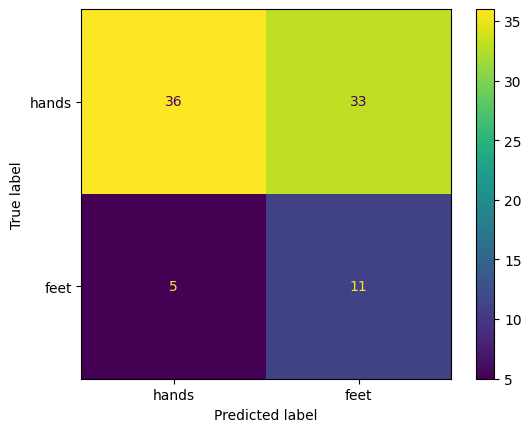

In [253]:
disp1 = ConfusionMatrixDisplay(confusion_matrix_1, display_labels = names)
disp1.plot()

# disp2 = ConfusionMatrixDisplay(confusion_matrix_2, display_labels = names)
# disp2.plot()

In [261]:
l = compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(number_of_examples=X_train.shape[0],
                      batch_size=batch_size,
                      noise_multiplier=noise_multiplier,
                      num_epochs=100,
                      used_microbatching=True,
                      max_examples_per_user=96,
                      delta=1e-5)
print(l)

/opt/anaconda3/envs/zazu2/lib/python3.11/site-packages/tensorflow_privacy/privacy/analysis/compute_dp_sgd_privacy_lib.py:152: RuntimeWarning: invalid value encountered in scalar subtract
  example_log_delta + _logexpm1(user_eps) - _logexpm1(example_eps)


DP-SGD performed over 224 examples with 16 examples per iteration, noise
multiplier 1.5 for 100 epochs with microbatching, and at most 96 examples per
user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:       151.133
    Epsilon assuming Poisson sampling (*):                     41.068

User-level DP with add-or-remove-one adjacency at delta = 1e-05 computed using
RDP accounting and group privacy:
    Epsilon with each example occurring once per epoch:      inf (**)
    Epsilon assuming Poisson sampling (*):                   inf (**)

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.

(*